# Moving Company Exploratory Data Analysis

Imports the Google Calendar information from a moving company and describes relevant data.

We need the Python library _icalendar_ to parse the Google Calendar.

In [1]:
from icalendar import Calendar, Event

Let's create a Python dictionary to hold the data from the moving jobs

In [2]:
jobs = {}
i = 0

The text fields (summary and description) have newlines (/n) and $. We need a method for Python to correctly interpret these.

## I'm not sure I understand the notes in the DESCRIPTION field

It seems like it is some shorthand on how many hours the job took, what the hourly rate will be, how many movers are needed, etc. It's going to be difficult to parse this, but we'll take a stab at it with some regular expressions.

In some cases, I think they are listing the hourly rate. In other cases, I think they are listing the total charge. I need some sort of client decision on how to tell which is which. Of course, there are some cases where they have more than 5 movers so that might explain the high hourly rates (5 movers x \$50/hr = \$250/hr)

In [3]:
import re

'''
Extract the hourly rate
This should be in the description after the dollar sign.
However, this should be checked with the client.
I think sometimes the number is the hourly rate and other times it is the total charge.
So use a regular expression
'''
def extractRate(text):
    
    rate = re.findall(r'[\$]{1}\d+\.?\d{0,2}',text)
    if len(rate) > 0:  # Only return first dollar amount found
        rate = float(rate[0][1:])   # Strip dollar sign and return decimal only
    else:
        rate = None
    return rate

In [4]:
def extractEmail(text):
    
    email = re.findall(r'\w+@[\w.-]+|\{(?:\w+, *)+\w+\}@[\w.-]+',text.replace('\\n', ' '))
    if len(email) > 0:
        email = email[0]
    else:
        email = None
        
    return email


In [5]:
def raw(text):
    return text

The _icalendar_ library parses the calendar. For every _event_ in the calendar, we check to see which fields are present.

In [6]:
def parseKeys(component):
    
      
    if component.has_key('DTSTART'):
            DTSTART = component.get('DTSTART').to_ical()
    else:
        DTSTART = None

    if component.has_key('DTEND'):
        DTEND = component.get('DTEND').to_ical()
    else:
        DTEND = None

    if component.has_key('RRULE'):
        RRULE = component.get('RRULE').to_ical()
    else:
        RRULE = None

    if component.has_key('DTSTAMP'):
        DTSTAMP = component.get('DTSTAMP').to_ical()
    else:
        DTSTAMP = None

    if component.has_key('UID'):
        UID = component.get('UID').to_ical()
    else:
        UID = None

    if component.has_key('CREATED'):
        CREATED = component.get('CREATED').to_ical()
    else:
        CREATED = None

    if component.has_key('DESCRIPTION'):
        DESCRIPTION = raw(component.get('DESCRIPTION').to_ical())
        HOURLYRATE = extractRate(DESCRIPTION)
        EMAIL = extractEmail(DESCRIPTION)
    else:
        DESCRIPTION = None
        HOURLYRATE = None
        EMAIL = None

    if component.has_key('LAST-MODIFIED'):
        LASTMODIFIED = component.get('LAST-MODIFIED').to_ical()
    else:
        LASTMODIFIED = None

    if component.has_key('LOCATION'):
        LOCATION = component.get('LOCATION').to_ical()
    else:
        LOCATION = None

    if component.has_key('SEQUENCE'):
        SEQUENCE = component.get('SEQUENCE').to_ical()
    else:
        SEQUENCE = None

    if component.has_key('SUMMARY'):
        SUMMARY = raw(component.get('SUMMARY').to_ical())
    else:
        SUMMARY = None

    if component.has_key('TRANSP'):
        TRANSP = component.get('TRANSP').to_ical()
    else:
        TRANSP = None


    return [DTSTART,
            DTEND,
            RRULE,
            DTSTAMP,
            UID,
            CREATED,
            DESCRIPTION,
            HOURLYRATE,
            EMAIL,
            LASTMODIFIED,
            LOCATION,
            SEQUENCE,
            SUMMARY,
            TRANSP]

Now go through the file and parse the moving jobs into the dictionary

In [7]:
fileName = 'vectormovingsd@gmail.com.ics'

with open(fileName,'rb') as fp:
    gcal = Calendar.from_ical(fp.read())
    for component in gcal.walk():
    
        if component.name == 'VEVENT':
         
            jobs[i] = parseKeys(component)

            i += 1
    
fp.close()

Let's put the jobs into Pandas

In [8]:
import pandas as pd

In [9]:
dfJobs = pd.DataFrame.from_dict(jobs, orient='index')
dfJobs.columns = ['DTSTART',
                  'DTEND',
                  'RRULE',
                  'DTSTAMP',
                  'UID',
                  'CREATED',
                  'DESCRIPTION',
                  'HOURLY RATE',
                  'EMAIL',
                  'LAST MODIFIED',
                  'LOCATION',
                  'SEQUENCE',
                  'SUMMARY',
                  'TRANSP']

In [10]:
del jobs   # Free up memory

Let's convert the time/date stamps to correct format.

In [11]:
dfJobs['DTSTART'] = pd.to_datetime(dfJobs['DTSTART'])
dfJobs['DTEND'] = pd.to_datetime(dfJobs['DTEND'])
dfJobs['DTSTAMP'] = pd.to_datetime(dfJobs['DTSTAMP'])
dfJobs['CREATED'] = pd.to_datetime(dfJobs['CREATED'])
dfJobs['LAST MODIFIED'] = pd.to_datetime(dfJobs['LAST MODIFIED'])

# Sanity check

Note that the DESCRIPTION and SUMMARY fields differ in the hourly rate (\$55 vs. \$60/hr)

In [17]:
dfJobs.ix[40]

DTSTART                                        2013-09-06 22:00:00
DTEND                                          2013-09-06 23:00:00
RRULE                                                         None
DTSTAMP                                        2016-11-29 12:31:58
UID                          galblf8rorplcgmdmb7aqtcst8@google.com
CREATED                                        2013-09-04 19:00:55
DESCRIPTION      yelp.com\ncholleti15@yahoo.com\n3 hours $55/hr...
HOURLY RATE                                                     55
EMAIL                                         cholleti15@yahoo.com
LAST MODIFIED                                  2013-09-09 17:33:20
LOCATION              9175 Judicial Dr apt 6412 San Diego Ca 92122
SEQUENCE                                                         0
SUMMARY          Hanu Cholleti 858-752-7580 $60/hr 3 hours from...
TRANSP                                                      OPAQUE
Name: 40, dtype: object

In [20]:
dfJobs.ix[1200]

DTSTART                                        2014-09-04 14:00:00
DTEND                                          2014-09-04 17:30:00
RRULE                                                         None
DTSTAMP                                        2016-11-29 12:31:58
UID                          13jomfb9fhjn6lq51d3gvc38h4@google.com
CREATED                                        2014-08-14 19:28:05
DESCRIPTION                                    kajrswift@yahoo.com
HOURLY RATE                                                    NaN
EMAIL                                          kajrswift@yahoo.com
LAST MODIFIED                                  2014-08-22 22:34:29
LOCATION                 3885 Creststone Pl\, San Diego\, CA 92130
SEQUENCE                                                         0
SUMMARY          Cancelled 8-9 full packing KAY Swift 2bdr 415-...
TRANSP                                                      OPAQUE
Name: 1200, dtype: object

In [81]:
import matplotlib.pyplot as plt
%matplotlib inline

import matplotlib.dates as mdates

import seaborn as sns
sns.set(color_codes=True)


# Plot histogram of the number of jobs per month

In [71]:
d = dfJobs['DTSTART'].groupby([dfJobs['DTSTART'].dt.year, dfJobs['DTSTART'].dt.month]).count()

In [72]:
d.index

MultiIndex(levels=[[2013, 2014, 2015, 2016], [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]],
           labels=[[0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3], [7, 8, 9, 10, 11, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]],
           names=[u'DTSTART', u'DTSTART'])

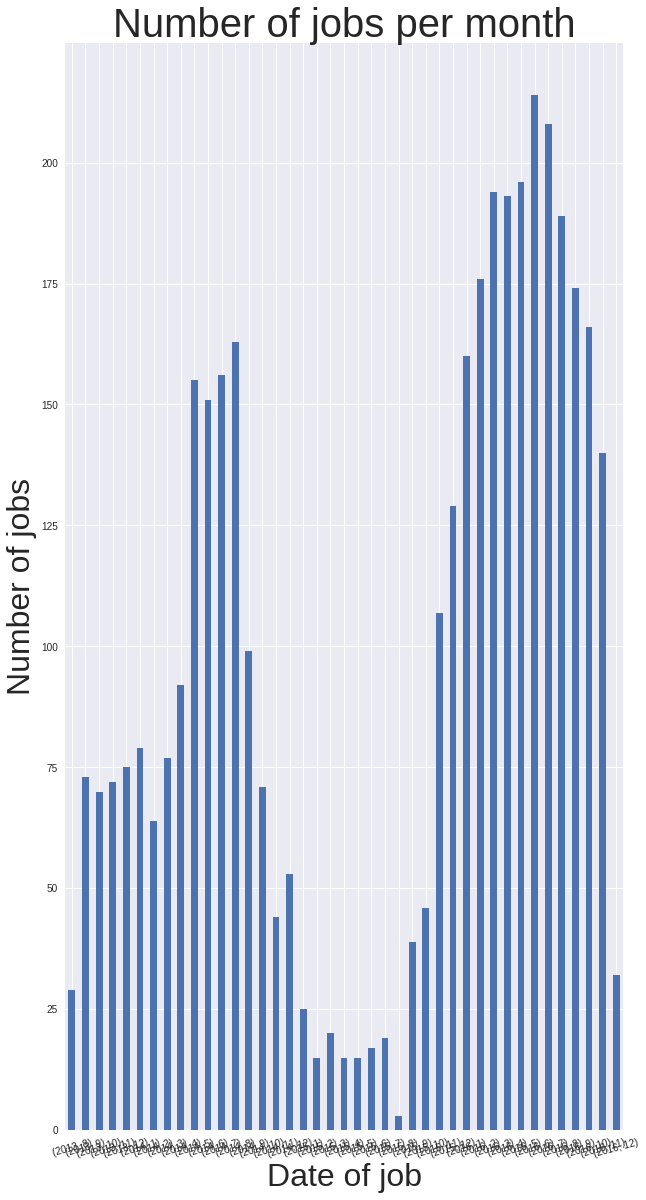

In [86]:
ax = dfJobs['DTSTART'].groupby([dfJobs['DTSTART'].dt.year, dfJobs['DTSTART'].dt.month]).count().plot(kind="bar", 
                                                                                                     rot=15,
                                                                                                     figsize=(10,20));


#ax.xaxis.set_major_locator(mdates.YearLocator())
#monthFmt = mdates.DateFormatter('%YYYY')
#ax.xaxis.set_major_formatter(monthFmt)

plt.xlabel('Date of job', fontsize=32);
plt.ylabel('Number of jobs', fontsize=32);
plt.title('Number of jobs per month', fontsize=40);

# There's definitely a variation in the jobs over time. 

Not as many moving jobs during the winter period. 2015 was a very bad year. Summer better than winter. September through November is worst for jobs. Although in 2016, there was a spike in jobs in 

In [33]:
dfJobs['DTSTART'].groupby([dfJobs['DTSTART'].dt.year, dfJobs['DTSTART'].dt.month]).count().shape

(41,)